In [44]:
# Import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer


In [45]:
# Read the accident data from csv
violation_df = pd.read_csv('Traffic_Violations-api.csv', 
                           parse_dates = [['Date Of Stop', 'Time Of Stop']],
                           infer_datetime_format = True)


In [46]:
violation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384236 entries, 0 to 1384235
Data columns (total 34 columns):
Date Of Stop_Time Of Stop    1384236 non-null datetime64[ns]
Agency                       1384236 non-null object
SubAgency                    1384226 non-null object
Description                  1384227 non-null object
Location                     1384234 non-null object
Latitude                     1283334 non-null float64
Longitude                    1283334 non-null float64
Accident                     1384236 non-null object
Belts                        1384236 non-null object
Personal Injury              1384236 non-null object
Property Damage              1384236 non-null object
Fatal                        1384236 non-null object
Commercial License           1384236 non-null object
HAZMAT                       1384236 non-null object
Commercial Vehicle           1384236 non-null object
Alcohol                      1384236 non-null object
Work Zone                    

In [47]:
#change the index to datetime
violation_df.index = violation_df['Date Of Stop_Time Of Stop']

#delete data with Nan
viol_df_clean = violation_df.dropna(how = 'any')

#This eliminates unncessary and duplicate columns from the data
viol_df_clean = viol_df_clean.drop(['Agency','Driver State','State', 'Geolocation',
                                  'Driver City','Charge', 'Location'], 
                                   axis = 1)

# transforms the race column into white and non-white
race_cate = (viol_df_clean.Race.unique())
race_cate = race_cate[race_cate != 'WHITE']

viol_df_clean.loc[:,'Race'].replace(to_replace = race_cate, 
                                    value = 'race_Others', 
                                    inplace = True)

# Transforms the vehicle_list column into auto and non_auto
auto_cate = viol_df_clean.VehicleType.unique()
auto_cate = auto_cate[auto_cate != '02 - Automobile']

viol_df_clean.loc[:, 'VehicleType'].replace(to_replace = auto_cate,
                                            value = 'Non-AUTO',
                                            inplace = True)


# Transforms the DL state into MD and out of state category
dl_cate = viol_df_clean['DL State'].unique()
dl_cate = dl_cate[dl_cate != 'MD']

viol_df_clean.loc[:,'DL State'].replace(to_replace = dl_cate, 
                                        value = 'Out-ofSTATE',
                                        inplace = True)

# This selects the columns that are categorical 
df_categorical = viol_df_clean[['Accident', 'Belts', 'Personal Injury', 'Property Damage', 'Fatal',
                                'Commercial License', 'HAZMAT', 'Commercial Vehicle', 'Alcohol',
                                'Work Zone', 'VehicleType', 'Violation Type', 'Article',
                                'Contributed To Accident','Race', 'Gender', 'DL State']]

# copy the categorical columns so that it forgets the origional indices
df_cat = df_categorical.copy(deep =  False)

# Translate the data into dummy binary
df_cat_dumm = pd.get_dummies(df_cat, drop_first = True)

# numerical portion of the data 
df_numerical = viol_df_clean[['Latitude', 'Longitude', 'Year']]

# This data can't be converted into binary dummy but still keep it
df_none = viol_df_clean[['Description', 'Make', 'Model', 'Color' ]]

# combine all the data
df_traffic = pd.concat([df_cat_dumm, df_numerical, df_none], axis = 1)


8.0


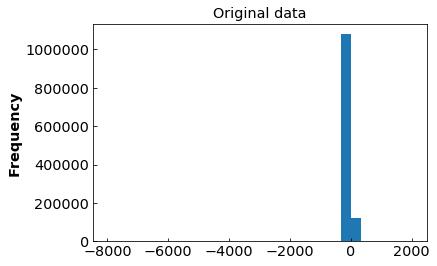

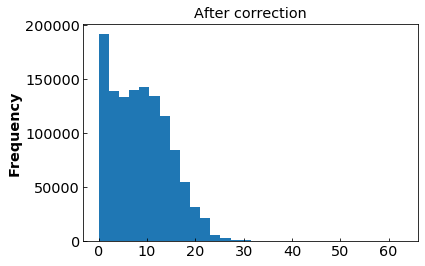

In [48]:
# We calculate age of vehicle by subtracting the year column from the time it gets pulled over. This column contains some 
# outliers: There are some negative values and some high positive values. We replace the outliers by median value of data 
# from non-outlier data. 
df_traffic['datetime'] = df_traffic.index

df_traffic['V_Age'] =  df_traffic.datetime.dt.year - df_traffic.Year 

real_bool = (df_traffic.V_Age <= 70) & (df_traffic.V_Age >= 0)

year_med = np.median(df_traffic[real_bool].V_Age)
print(year_med)

df_traffic.V_Age.plot(kind = 'hist', bins = 30)
plt.title('Original data')
plt.show()

df_traffic.V_Age = df_traffic[['V_Age']].where(real_bool, year_med)
df_traffic.V_Age.plot(kind = 'hist', bins = 30)
plt.title('After correction')
plt.show()

In [49]:
# The description column is full of text. We vectorize the test so that we can fit it into the model. 
corpus = df_traffic.Description

vectorizer = CountVectorizer(stop_words = 'english', 
                             strip_accents = 'ascii', 
                             min_df = 0.025, 
                             max_features = 100,
                             token_pattern='[a-z]+',
                             max_df = 0.25,
                             binary  = True)

X = vectorizer.fit_transform(corpus)

"""This translates text in each column as a vector array of following basis (keywords)"""

print(vectorizer.get_feature_names())

['alcohol', 'authorization', 'card', 'control', 'demand', 'device', 'display', 'displaying', 'drive', 'driver', 'exceeding', 'expired', 'fail', 'handheld', 'hands', 'highway', 'hwy', 'individual', 'instructions', 'issued', 'lamps', 'license', 'lighted', 'limit', 'line', 'maximum', 'motion', 'motor', 'mph', 'o', 'obey', 'officer', 'person', 'placed', 'plate', 'plates', 'police', 'posted', 'privilege', 'properly', 'property', 'public', 'rear', 'reasonable', 'red', 'registration', 'required', 'right', 'sign', 'signal', 'speed', 'state', 'stop', 'suspended', 'telephone', 'traffic', 'uniformed', 'use', 'using', 'veh', 'w', 'whilemotor', 'zone']


In [50]:
# The description data in the form of 2D-array of vectors
X3 = X[:].toarray()

feature = vectorizer.get_feature_names()

df_traffic.drop('Description', axis = 1, inplace = True)
#convert the text data into a DataFrame
col_list = ['desc_'+ st for st in feature]
df_desc = pd.DataFrame(list(X3), columns= col_list)
df_desc.index = df_traffic.index

# combine two DataFrames
df = pd.concat([df_traffic, df_desc], axis = 1)


In [51]:
# Save dataframe as CSV
df.to_csv('data_wrangled.csv', columns = df.columns)